# State of the Art

The dual quaternionic representation of kinematics has gained steadily increasing popularity over the past decade. Many researchers have put great effort into robust trajectory tracking. However, covering all the work published to date is beyond the scope of this thesis. Therefore, this section provides an overview of the various approaches presented in literature to overcome the challenges in robotic trajectory tracking.

This chapter will cover the state of the art of current standard solutions for trajectory tracking of redundant robots and explain the fundamentals in rough detail. It will examine the state of the art of forward kinematics, differential kinematics, and the application of differential kinematics to redundant robots. Finally, the chapter will discuss the application of dual quaternions to these approaches and the available literature. A comparison of the current state of the art will be presented, highlighting the lack of robust singularity handling during robot trajectory tracking.

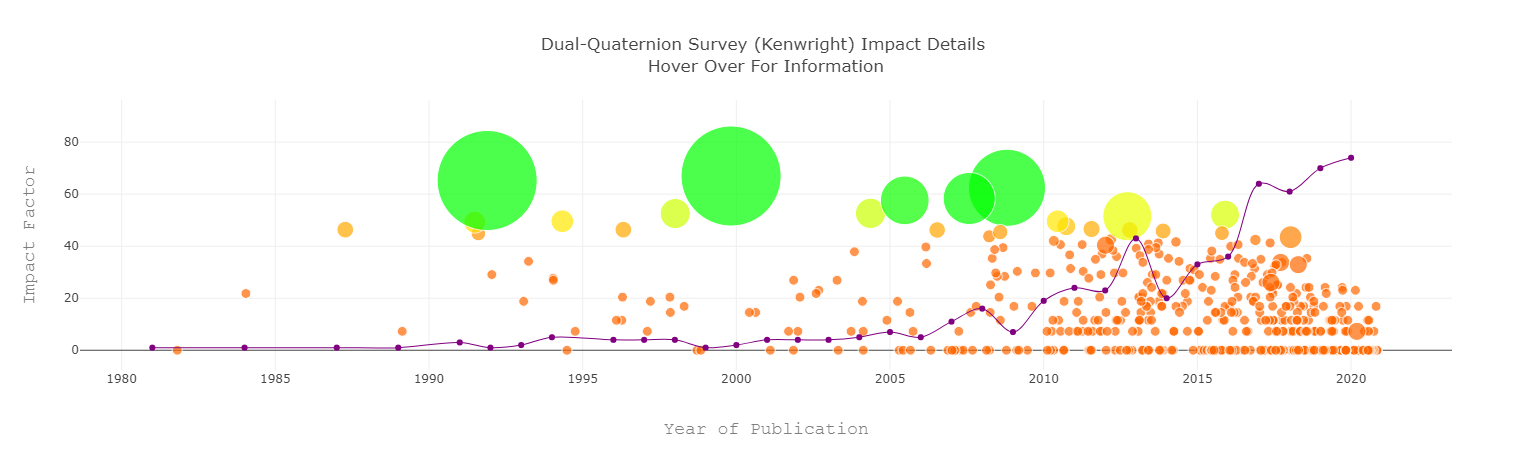

<p style="text-align:center">Figure 1: Impact factor for each publication over the years, also a line plot showing the total number of articles and publications published each year <cite id="1qdie"><a href="#zotero%7C16222978%2FKDMVUXCW">(Kenwright, 2023)</a></cite> </p>

## Unit Dual Quaternionic Preliminaries

Before discussing the state of the art in Kinematics, Trajactory Tracking and Dual Quaternion Interpolation, an introduction to dual quaternions is given as the mathematical concept of dual quaternions and lie algebra is still not wide spread knowledge. 

Orientation representation in robotics is most commonly done with the Special Orthogonal Group in three dimensions $\mathcal{SO}(3)$. This group consists of orthogonal rotation matrices $R \in \mathbb{R}^{3 \times 3}$ with determinant $1$. In robotics the elements $\mathcal{SO}(3)$ can be parametrized in various ways. Common methods are Euler Angles and the axis-angle representation <cite id="p0bnm"><a href="#zotero%7C16222978%2FZV86QVV9">(Alaimo et al., 2013)</a></cite>, <cite id="k64ro"><a href="#zotero%7C16222978%2FTPTTZSUA">(Stuelpnagel, 1964)</a></cite>.

Three dimensional rigid transformations are usually represented by the Special Euclidean Group $\mathcal{SE}(3)$ which is a semi-direct product of $\mathcal{SO}(3)$ and $\mathbb{R}^{3}$.

$$
\mathcal{SE}(3) = \mathcal{SO}(3) \ltimes \mathbb{R}^{3}
$$

It includes both rotations and translations. It is represented by a homogeneous transformation matrix $T \in \mathbb{R}^{4 \times 4}$ that combines a $3 \times 3$ rotation matrix from $\mathcal{SO}(3)$ and a $3 \times 1$ translation vector from $\mathbb{R}^{3}$.

Analogously, the unit dual quaternion space $\mathcal{H}_u$ combines elements from $\textrm{Spin}(3)$, which is the double cover of the $\mathcal{SO}(3)$ rotation group. Elements from $\textrm{Spin}(3)$ are represented by unit quaternions $\hat{q} \in \textrm{Spin}(3)$. The double cover aspect means that each rotation in $\mathcal{SO}(3)$ corresponds to two unit quaternions in $\textrm{Spin}(3)$, namely the quaternion $\hat{q}$ and its negative $-\hat{q}$. Note that $\textrm{Spin}(3)$ has a natural correspondance to the four dimensional unit hypersphere $\mathcal{S}^3$. Each point on $\mathcal{S}^3$ corresponds to a unit quaternion, thus $\mathcal{S}^3$ and $\textrm{Spin}(3)$  are the same set. In the remainder of the thesis $\mathcal{S}^3$ and $\textrm{Spin}(3)$ will be used interchangably. Quaternions and unit quaternions will be explained in further detail in later chapters, here the understanding of the metioned properties are deepened and a python code representation is introduced.

The unit dual quaternion space is then given by the semi-direct product of $\textrm{Spin}(3)$ and $\mathbb{R}^{3}$: 

$$
\mathcal{H}_u = \textrm{Spin}(3) \ltimes \mathbb{R}^{3}
$$

which similary to the unit quaternions, is double covering the Special Euclidean Group $\mathcal{SE}(3)$. A unit dual quaternion $\underline{\xi} \in \mathcal{H}_u$ can be written as

$$
\underline{\xi} = \hat{r} + \epsilon \frac{1}{2}\bar{t} \otimes \hat{r}
$$

where $\hat{r} \in \textrm{Spin}(3)$ is a unit quaternion, $\bar{t} \in \mathbb{R}^{3}$ is a pure quaternion and $\epsilon$ is the dual unit with the property $\epsilon^2 = 0$. The resulting unit dual quaternion is thus a six dimensional manifold embedded in $\mathbb{R}^8$. The manifold is not equivalent to $\mathbb{R}^6$ because of two extra constraints <cite id="q80ok"><a href="#zotero%7C16222978%2FFUREQTMV">(Selig, 2005)</a></cite>, <cite id="oa0jc"><a href="#zotero%7C16222978%2FSM8I8YUP">(Adorno, 2017)</a></cite>. 

The aforementioned constraint are:
- **Norm Constraint**: the norm of a unit dual quaternion and its conjugate must be one. $\underline{\xi}\underline{\xi}^* = 1$.
- **Dual Number Constraint**: The dual part of the unit dual quaternion must conform to the properties of the dual numbers, namely $\epsilon^2 = 0$.

It can be seen that classic homogeneous transformation matrices and unit dual quaternions represent the same concept, with the difference that a unit dual quaternion is more compact and has the extra information content of the double cover property. This will be used later as inherent benefit of the motion-planning algorithm. Further insights about unit dual quaternion algebra will be given in following chapters and would exceed the current scope.

## Forward Kinematics

Robotic manipulators are typically described as a series of rigid bodies that are connected by joints. The most common joint type for cobots are revolute joints, which this thesis followingly focusses on. The configuration of the multibody system with $n$ joints is fully described by its joint space configuration $\theta \in \mathbb{R}^n$. The forward kinematics or direct kinematics $x = fk(\theta) \in \mathbb{R}^m$ describes the robots taskspace configuration or pose of the end-effector as a function of the joint angles $\theta$. The taskspace can be chosen to either lie in the cartesian space $\mathbb{R}^6$ or in dual-quaternion space $\mathbb{H}$, which is a hypersurface embedded in the higher dimensional $\mathbb{R}^8$.

At the base of each robotic systems the forward kinematics convetion has to be chosen. Here, three common types can be found in literature, the well know Denevit-Hartenberg-Convention (DH-Convention) <cite id="2x3gw"><a href="#zotero%7C16222978%2F42TNDPMV">(Denavit &#38; Hartenberg, 1955)</a></cite> and its variations like modified-DH <cite id="fon6n"><a href="#zotero%7C16222978%2FW8EF482S">(A Chennakesava Reddy, 2014)</a></cite>, the matrix exponential approach which was made popular by Lynch and Park <cite id="l21y5"><a href="#zotero%7C16222978%2FUIFPWU6T">(Lynch &#38; Park, 2017)</a></cite> and the Elemental Transform Sequence (ETS) approach which was introduced by Jesse Haviland and Peter Corke <cite id="ljwoc"><a href="#zotero%7C16222978%2FWHL4UY7J">(Haviland &#38; Corke, 2020)</a></cite>. 
These methods will be briefly introduced and compared. An extension to dual quaternion algebra is possible for all cases, as it can be seen as an alternative to the popular matrix representation.

#### Denavit-Hartenberg (DH) Convention
The Denavit-Hartenberg (DH) Convention is a standardized and minimal representative method to express the kinematic geometry of robotic arms. This approach simplifies the complex kinematic structure of a robot into a series of simple transformations. Each joint and link of the robot is represented by four parameters: link length $d$, link offset $a$, link twist $\alpha$, and joint angle $\theta$.

$$
T_{DH}(\theta, d, a, \alpha) = R_z(\theta)T_z(d)T_x(a)R_x(\alpha)
$$

These parameters define the transformation from one link to the next. The DH Convention has been widely adopted due to its systematic approach, allowing for a structured and simplified, yet restrictive representation of the robot's kinematics. The extension to a representation that is based on dual quaternions is possible but uncommon as the computation is quite intricate and inefficient compared to the other approaches <cite id="g173v"><a href="#zotero%7C16222978%2FG9TWKM5T">(Radavelli et al., 2012)</a></cite>, and thus not very common in literature.

#### Elemental Transform Sequence
The Elemental Transform Sequence is a modern approach that offers an alternative to the DH method. ETS breaks down the kinematics into a series of elementary transformations, which can be easily understood and visualized. This method provides a more intuitive way of representing robot kinematics, especially for those with complex or unconventional structures. Unlike the DH method, ETS does not impose a fixed order of transformations, granting more flexibility in defining the kinematic chain.

#### Matrix Exponential Approach
Moving beyond representations based on elementary transformations, the matrix exponential approach offers a more versatile representation of kinematics. It is grounded in the concept of Lie groups and Lie algebras, where the kinematics are expressed in terms of exponential coordinates. These exponential coordinates are expressed as Screws for spatial transformations in practice, and as scaled rotation axis for rotations. 

The rotation matrix exponential <cite id="itecm"><a href="#zotero%7C16222978%2FUIFPWU6T">(Lynch &#38; Park, 2017)</a></cite> is

$$
\begin{align*}
R &= e^{[\tilde{\omega}]_{\times} \theta} \\
&= I + \sin\theta[\tilde{\omega}]_{\times} + (1 - \cos\theta)[\tilde{\omega}]_{\times}^2
\end{align*}
$$

where $[\tilde{\omega}]_{\times}$ denotes the skew-symmetric matrix of the unit-length rotation axis $\tilde{\omega$. And the spatial tranformation via matrix exponential

$$
\begin{align*}
T &= e^{[S]_{\times} \theta} \\
&= \begin{bmatrix}
e^{[\tilde{\omega}]_{\times}\theta} & (I\theta + (1 - \cos\theta)[\tilde{\omega}]_{\times} + (\theta - \sin\theta)[\tilde{\omega}]_{\times}^2)\vec{v} \\
0 & 1
\end{bmatrix}.
\end{align*}
$$

Here, $S$ defines the screw which is composed of the rotational axis $\tilde{\omega}$ and the moment $\vec{v} = \vec{p} \times \tilde{\omega}$, which is the cross product of the screws position $\vec{p}$ and the rotation axis $\tilde{\omega}$.

This method is particularly effective in handling the kinematics of complex robotic systems, including those with closed chains and singular configurations. The matrix exponential approach provides a compact and elegant way to represent the kinematic equations, facilitating efficient computation and analysis. Extension to a dual quaternionic representation is natural as dual quaternions leverage the exponential formulation based on screw theory.

As shown in <cite id="wojio"><a href="#zotero%7C16222978%2FGF7XZFAM">(Shahidi, 2023)</a></cite>, <cite id="nocqo"><a href="#zotero%7C16222978%2FSM8I8YUP">(Adorno, 2017)</a></cite> and many other publications, the dual quaternion exponential formula can be written as 

$$
\underline{\xi} = e^{\frac{\underline{\theta}}{2}\underline{s}} = \cos(\frac{\underline{\theta}}{2}) + \underline{s} \sin(\frac{\underline{\theta}}{2})
$$

with dual angle $\underline{\theta} = \theta + \epsilon d$ and dual vector $\underline{s} = (0,\tilde{\omega}) + \epsilon (0,\vec{v})$. Note that $d = 0$ for revolute joints, which corresponds to the formulation in <cite id="1wr4c"><a href="#zotero%7C16222978%2FUIFPWU6T">(Lynch &#38; Park, 2017)</a></cite>. This formulation was chosen to describe the kinematics throughout this thesis as it posseses many algebraic and analytic advantages over the ETS and the more classical DH representation, and will be further explained in the methodology chapters.



## Inverse Kinematics

Inverse Kinematics (IK) is a fundamental aspect of robotic control, central to the translation of desired end-effector positions and orientations into the necessary joint configurations. This subchapter explores the state of the art of IK methodologies, from analytical techniques to the contemporary landscape dominated by inverse differential kinematics, underscoring the pivotal advancements and diverse approaches that have shaped this field.

#### Analytic/Geometric Inverse Kinematics
One standard approach to solve the inverse kinematics problem is to find analytical, closed-form solutions to the forward kinematics <cite id="wul4q"><a href="#zotero%7C16222978%2FJTQ8HGEP">(Sun et al., 2017)</a></cite>, <cite id="uismn"><a href="#zotero%7C16222978%2FPSIMY75M">(Wang et al., 2018)</a></cite>. Analytical solutions have the advantage that they are very fast to compute, typically only several microseconds (quelle Sicillainio) and that it is possible to obtain all possible solutions for simpler, non-redundant robotic systems. These methods, while intuitive, are limited in scope and applicability, especially as robotic systems and task requirements grew in complexity. They are robot specific and require a certain structure of the kinematics in order to be solvable, which is not always the case for modern systems.

Finding robust solutions for redundant robots is possible but the complexity of defining extra conditions grows exponentially as redundant robots often have infinite IK solutions in the case they are not singular (quelle).

Besides the aforementioned drawbacks, analytical solutions do not guarantee to give locally smooth solutions between adjacent solutions. This can lead to jumps in joint position commands, making them hard to use for trajectory tracking tasks.

#### Iterative, Jacobian based Inverse Kinematics
To fullfill the growing requirements on the inverse kinematics, numerical methods have been derived, particularly iterative techniques that use the manipulator Jacobian $J(\theta)$ to progressively converge to the desired end-effector pose. Starting from a refernce joint angle $\theta_{ref}$, which serves as an initial guess to the solution of the inverse kinematics, an iterative optimization algorithm is called to converge to the desired task space configuration $x_{des}$. 

$$
\Delta \theta = J^{-1} \Delta x
$$

where $\Delta \theta$ represents the change in joint angles, $J^{-1}$ is the inverse of the manipulator Jacobian and $\Delta x$ is the difference between the current and desired end-effector pose.

These methods are generalizable and applicable to a broad range of cobots <cite id="d01gl"><a href="#zotero%7C16222978%2FBPUMZXI3">(Goldenberg et al., 1985)</a></cite>. Iterative inverse kinematics do not have the requirement of intersecting axis, which are common in geometric/analytical approaches, allowing to also find the IK solution for calibrated robots. These features give numerical methods a high value in industrial applications, given their ease of use and their ability to fullfill the high requirements in accuracy and flexibility of modern applications. However, besides the numerous advantages named above, they have the drawback that iterative methods are relatively slow in finding a suitable inverse kinematics solution. Many forward kinematics evaluations are needed which results in solutions times of several hundred microseconds, depending on the initial guess $\theta_{ref}$. A popular open-source iterative IK solver is KDL which is based on the Jacobian pseudo-inverse method <cite id="yhtpk"><a href="#zotero%7C16222978%2FUWNXCEW6">(Smits, 2023)</a></cite>.

Optimization algorithms emerged as another powerful tool, framing the IK problem as an optimization task. This perspective allowed for the minimization of errors between the desired and actual end-effector positions, further expanding the utility of IK in complex robotic applications, as these methods offer the easy integration of boundary conditions and extra optimization critera. A common IK based on optimization is the well known TRAC-IK library <cite id="s2pdj"><a href="#zotero%7C16222978%2FCX5ZL77E">(Beeson &#38; Ames, 2015)</a></cite>.

Dantam formulated a position based IK leveraging the benefitial dual quaternion algebra, which achieved a speed-up of $300-500\%$ compared to TRAC-IK, by incorperation of efficient gradient computation in dual quaternion space instead of the numerical differentiation used in the TRAC-IK library <cite id="80412"><a href="#zotero%7C16222978%2FAFEHQ7QJ">(Dantam, 2021)</a></cite>.

#### Inverse Differential Kinematics
Inverse Differential Kinematics (IDK) are based on the same concepts as the iterative IK algorithms. Instead of iteratively reducing the error between the current end-effector and the desired end-effector pose, the inverse differential kinematics shifts the focus to the robot's velocity level, computing the desired joint velocities $\dot{\theta}$ based on the desired end-effector velocity $\dot{x}$. The desired joint configuration $\theta(t)$ is then found via numerical integration.

$$
 \dot{\theta} = J^{-1} \dot{x}
$$

Differential Kinematics are vital for dynamic tasks requiring real-time solutions. This method's integration into control systems has been instrumental in achieving smoother and more responsive robot movements. They have the benefit that only one evaluation per cycle is needed to compute the desired joint velocity, which makes them applicable in real-time environments. Besides that they are locally smooth if not singular, which deminishes the need for i.e. extra smoothness checks. However, as these solutions are applied on velocity level, they are prone to drift and they are mostly not well defined if the jacobian loses rank in singular configurations, which requires special attention. This is usually done by formulation of the inverse differential kinematics as closed loop system, with position feedback to counter the numerical drift of the integration, which is usually called Closed Loop Inverse Kinematics (CLIK) *(quelle clik)* and the application of a variety of algorithms and methods to make the jacobian inversion singularity robust *(quelle singularity robust)*.

The CLIK algorithm is typically written by the simple addition of $e$, which is the error between the actual and desired end-effector pose depending on the chosen convention, and a positive proportional gain $k_p$.

$$
 \dot{\theta} = J^{-1} (\dot{x} + k_p e)
$$

Other sources state the extension to PD control, by addition of the velocity error (quelle clik2), but in practice the simple P controller suffices. As the minimum norm solution is often desirable and the IDK problem is underdetermined in the case of redundant robots, instead of the Jacobian inverse $J^{-1}$ the left-sided moore penrose pseudo-inverse  is often chosen $J^\dagger = (J^TJ)^{-1} J^T$ <cite id="ateel"><a href="#zotero%7C16222978%2FN24UUJMB">(Penrose, 1955)</a></cite>.

A common approach in literature is the formulation of the differential kinematics problem as Quadratic Program (QP). The basic minimum norm differential kinematics problem can be written as

$$
\begin{align*}
\min_{\dot{\theta}}& \; f(\dot{\theta}) = \frac{1}{2} \dot{\theta}^T \dot{\theta}\\
\textrm{s. t. }& \; J\dot{\theta} = \dot{x} \\
\end{align*}
$$

The QP approach allows for the incorporation of various extra constraints that can be linear with respect to the joint velocities, making it particularly well-suited for real-time applications where safety, stability, and adherence to physical limits are critical. The QP formulation also ensures that if a solution exists, it will be a global minimum due to the convex nature of the problem. Advanced QP solvers can efficiently handle high-dimensional problems, making this approach scalable to robots with a large number of degrees of freedom .


#### Robust Trajectory Tracking

To have a robust tracking behavior singularities and joint limits have to be taken into account. 
Haviland and Corke <cite id="6fiuq"><a href="#zotero%7C16222978%2F3ILGC5DC">(Haviland &#38; Corke, 2022)</a></cite>, <cite id="h270n"><a href="#zotero%7C16222978%2FN5B2VN4U">(Haviland &#38; Corke, 2022a)</a></cite> reformulated the standard QP approach to optimize the manipulability index defined by Yoshikawa <cite id="l160t"><a href="#zotero%7C16222978%2FB7SE9C3S">(Yoshikawa, 1985)</a></cite>. 

$$
m(\theta) = \sqrt{\det \left( J(\theta)J(\theta)^T \right)}
$$

This optimization happens as self-motion in the nullspace of the robotic manipulator. A null-space optimization will cause self-motion of the robot, without interference of the end-effector pose. This is a common approach to minimize joint angles, maximize the distance to kinematic singularities (increase the manipulability) or increase the distance to obstacles <cite id="36rri"><a href="#zotero%7C16222978%2FSFWH46CE">(De Luca &#38; Oriolo, 1990)</a></cite>. <br>
It can be written by the extension of the QP by an arbitrary gradient, in the case of Haviland and Corkes approach $J_m = \frac{\partial m(\theta)}{\partial \theta}$.

$$
\begin{align*}
\min_{\dot{\theta}}& \; f(\dot{\theta}) = \frac{1}{2} \dot{\theta}^T P \dot{\theta} - J_m^T \dot{\theta} \\
\textrm{s. t. }& \; J\dot{\theta} = \dot{x} \\
& \; \dot{\theta}_{min} \leq \dot{\theta} \leq \dot{\theta}_{max} \\
\end{align*}
$$

Besides the manipulability optimization to avoid singular configurations for their reactive motion planning, Haviland and Corke applied velocity dampening to avoid joint position limits and velocity bounds in their QP formulation. However, it doens't show predictive aspects and only optimizes for the current state of the robot. This makes it real-time applicable but purely reactive.

A predictive appraoch using Model Predictive Control (MPC) is shown by Faroni et al. <cite id="xfu2d"><a href="#zotero%7C16222978%2FY57A4KTA">(Faroni et al., 2017)</a></cite>. Here, the authors extend the classic QP by a state space representation of the relation of acceleration, velocity, and position as double integrator to predict the full state. They also incoorperate the minimum norm solution and joint limit avoidance and show improved smoothness of the solutions when compared to the standard QP solution. However, further optimization in regards to i.e. singularity robustness are not implemented and extensive model predictive appraoches are still computationally very expensive for higher degrees of freedom (commonly $7$ in the case of redundant cobot and possible task redundandy), which make them a less preferable choice for hard real-time environments. Faroni et al. implemented the predictive controller for a $4$ DoF robot, where problem seeding already exceeded $3.8ms$ with an average computation time of $0.45ms$ during the motionphase.

Reinhold et al. <cite id="plgwu"><a href="#zotero%7C16222978%2FMMUPDN2J">(Reinhold et al., 2023)</a></cite> proposed a Nonlinear Model Predictive Controller (NMPC) for a Stäubli TX2-90 6DoF robot, which shows computational times of $26 \pm 1$ms for the best case of the decomposed system and computational times of $130 \pm 12$ms up to $284 \pm 112$ms for the original full system. This is absolutely unacceptable for hard realtime systems which usually run at frequencies of $500 - 1000$ Hz.

## Comparison of current kinematics Methods

Comparing the state of the art and condensing the aformentioned details based on some key performance indexes (KPIs), the following table shows the benefits and drawbacks of the currently common methods. As we have the requirement of real-time applicability, the model predictive approaches are not usable because of their high computational demands. 

<table>
    <thead>
      <tr>
        <th style="width: 200px";>Feature</th>
        <th>position level IK</th>
        <th>IDK (classic)</th>
        <th>IDK (QP)</th>
        <th>MPC</th>
        <th>NMPC</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>real-time applicable</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
        <td>no</td>
        <td>no</td>
      </tr>
      <tr>
        <td>predictive approach</td>
        <td>no</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>nullspace projection</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>extra constraints</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>locally smooth</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
    </tbody>
  </table>
  
<p style="text-align: center">Table 1: Comparison of common kinematic methods</p>

The position level IK is not a good candidate for online inverse kinematics either as it is usually slow in the case of iterative IK methods and does not gurantee local smoothness. A good choice is the QP approach as it offers the application of extra constraint when compared to the classic IDK. This benefit and the fact that is applicable in a real-time scenario make it a good choice. However, as already stated current QP methods are purely reactive and don't take the evolution of the task in future time steps into account.

## Dual Quaternion Interpolation

To be able to leverage the algebraic properties of dual quaternions to be benefitial in the final trajectory tracking solution, the task interpolation is done with dual quaternions. This has key benefits if compared to more classical approaches like the orientation interpolation with euler angles as this representation is singularity-free and can directly be used in the dual quaternion differential kinematics without conversion to a spatial velocity for example.

Dual quaternion interpolation provides a compact representation of rigid body transformations and is less prone to singularities compared to matrix-based methods. It is computationally efficient and ensures continuity in the interpolated transformations, which is crucial for applications requiring smooth motion, such as robotic path planning and animation (quelle). These methods often respect the screw-linear nature of rigid body motion, interpolating both position and orientation in a unified framework.

The most basic dual quaternion interpolation linearly blends between two quaternions.

$$
\underline{\xi}(\alpha) =  \frac{(1-\alpha)\underline{\xi_1} + \alpha\underline{\xi_2}}{\|(1-\alpha)\underline{\xi_1} + \alpha\underline{\xi_2}\|} \textrm{, where } \alpha \in [0, 1]
$$

This interpolation method is known as Dual Quaternion Linear Blending (DLB) which can be found in the recent work of Kenwright <cite id="08tsf"><a href="#zotero%7C16222978%2F5A3HCSFF">(Kenwright, 2023b)</a></cite>. The work provides a good overview of basic dual quaternion interpolation methods. DLB  has the drawback that it does not possess constant linear / angular velocity during the interpolation, which explains why DLB and the derived versions of it are primarily used in computer graphics and animations and not in robotics, where a well defined velocity profile is needed.

Few other dual quaternion interpolation schemes are known where the feature of constant velocity is given, most commonly is the Screw Linear Interpolation (ScLERP), a generalization of SLERP <cite id="tl67i"><a href="#zotero%7C16222978%2FM23ULJLX">(Shoemake, 1985)</a></cite> which linerly interpolates in the tangent space of the dual quaternion, resulting in a screw shaped interpolation in cartesian space. If the resulting trajectory is screw shaped, the interpolation type is followingly called *coupled*. The DLB method also provides a coupled interpolation, which is useful in spefic scenarios like Character skinning in computer animation <cite id="c55ik"><a href="#zotero%7C16222978%2F5FJZJQGY">(Kavan et al., 2007)</a></cite>, but less so for robotics motion-planning.

More practical methods like SEP(LERP), which is the decoupled version of ScLERP, meaning that the orientation interpolation is done with SLERP and the translational interpolation is done linearly in cartesian space, and not in a screw motion as before, partially find usage in point-to-point (p2p) motion interpolation. 

Another method was presented, which is a scalable mix of ScLERP and SEP(LERP) called KenLERP <cite id="4b0ge"><a href="#zotero%7C16222978%2F5A3HCSFF">(Kenwright, 2023a)</a></cite>. Besides their common usage in Computer graphics and simple interpolation solutions, they lack applicability in the robotics field as they are not usable to solve complex motion tasks as they only interpolate between two key poses.

Kenwright and Allmerdinger <cite id="04ghc"><a href="#zotero%7C16222978%2FX58MLYJ3">(Allmendinger et al., 2018)</a></cite> proposed a method that is able to smoothly interpolate between a set of dual quaternions via the combination of De-Casteljau's algorithm and ScLERP. The resulting dual quaternionic bezier curves comes close to the needed solution but has the drawback of undulations between the key poses, meaning that the motion between the key poses cannot be fully defined on position level and only the key poses are hit precisely. Most trajectory tasks require the precise tracking of a given reference, often straight lines or circle segments as is the case for welding or application of paint or glue. Besides that, it is only $\mathcal{C}^1$ continuous, which is not satisfactory for robot trajectory tracking requirements. 

Wittmann (quelle SCB) proposed the Spherical Cubic Blend Method (SCB), which is able to interpolate as set of unit quaternions with $\mathcal{C}^2$ continuity in a directed way with blends at the way points. This method produces advanced velocity, acceleration and jerk limited trajectories in the Quaternion space $\mathcal{S}^3$, however lacks the translational interpolation.

## Comparison of current Interpolation Methods

A brief comparison of the mentioned interpolation methods shows the lack of applicability to modern and complex problems. Cobots are required to follow complex multipoint trajectories with a certain continuity to give satisfactory results, often on predefined motion profiles like lines and arcs which are specified by the user. Table 2 shows a comparison on current unit dual quaternion interpolation methods based on some key performance indexes.

<table>
    <thead>
      <tr>
        <th style="width: 200px";>Feature</th>
        <th>DLB</th>
        <th>ScLERP</th>
        <th>SEP(LERP)</th>
        <th>Bezier</th>
        <th>SCB</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>coupled interpolation</td>
        <td>yes</td>
        <td>yes</td>
        <td>no</td>
        <td>no</td>
        <td>-</td>
      </tr>
      <tr>
        <td>multipoint interpolation</td>
        <td>no</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>definable motion profiles</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
        <td>no</td>
        <td>-</td>
      </tr>
      <tr>
        <td>constant velocity</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>$\mathcal{C}^2$ continuity</td>
        <td>no</td>
        <td>no</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>translation interpolation</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>no</td>
      </tr>
      <tr>
        <td>orientation interpolation</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
    </tbody>
  </table>
  
  <p style="text-align: center">Table 2: Comparison of common dual quaternion interpolation methods</p>

# Literature

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|16222978/W8EF482S"></i>A Chennakesava Reddy. (2014). <i>DIFFERENCE BETWEEN DENAVIT - HARTENBERG (D-H) CLASSICAL AND MODIFIED CONVENTIONS FOR FORWARD KINEMATICS OF ROBOTS WITH CASE STUDY</i>. <a href="https://doi.org/10.13140/2.1.2012.9607">https://doi.org/10.13140/2.1.2012.9607</a></div>
  <div class="csl-entry"><i id="zotero|16222978/SM8I8YUP"></i>Adorno, B. (2017). <i>Robot Kinematic Modeling and Control Based on Dual Quaternion Algebra --- Part I: Fundamentals</i>.</div>
  <div class="csl-entry"><i id="zotero|16222978/ZV86QVV9"></i>Alaimo, A., Artale, V., Milazzo, C., &#38; Ricciardello, A. (2013). Comparison between Euler and Quaternion Parametrization in UAV Dynamics. <i>AIP Conference Proceedings</i>, <i>1558</i>, 1228–1231. <a href="https://doi.org/10.1063/1.4825732">https://doi.org/10.1063/1.4825732</a></div>
  <div class="csl-entry"><i id="zotero|16222978/X58MLYJ3"></i>Allmendinger, F., Charaf Eddine, S., &#38; Corves, B. (2018). Coordinate-invariant rigid-body interpolation on a parametric C1 dual quaternion curve. <i>Mechanism and Machine Theory</i>, <i>121</i>, 731–744. <a href="https://doi.org/10.1016/j.mechmachtheory.2017.11.023">https://doi.org/10.1016/j.mechmachtheory.2017.11.023</a></div>
  <div class="csl-entry"><i id="zotero|16222978/CX5ZL77E"></i>Beeson, P., &#38; Ames, B. (2015). TRAC-IK: An open-source library for improved solving of generic inverse kinematics. <i>2015 IEEE-RAS 15th International Conference on Humanoid Robots (Humanoids)</i>, 928–935. <a href="https://doi.org/10.1109/HUMANOIDS.2015.7363472">https://doi.org/10.1109/HUMANOIDS.2015.7363472</a></div>
  <div class="csl-entry"><i id="zotero|16222978/AFEHQ7QJ"></i>Dantam, N. T. (2021). Robust and efficient forward, differential, and inverse kinematics using dual quaternions. <i>The International Journal of Robotics Research</i>, <i>40</i>(10–11), 1087–1105. <a href="https://doi.org/10.1177/0278364920931948">https://doi.org/10.1177/0278364920931948</a></div>
  <div class="csl-entry"><i id="zotero|16222978/SFWH46CE"></i>De Luca, A., &#38; Oriolo, G. (1990). The Reduced Gradient Method for Solving Redundancy in Robot Arms. <i>IFAC Proceedings Volumes</i>, <i>23</i>(8), 133–138. <a href="https://doi.org/10.1016/S1474-6670(17)51725-5">https://doi.org/10.1016/S1474-6670(17)51725-5</a></div>
  <div class="csl-entry"><i id="zotero|16222978/42TNDPMV"></i>Denavit, J., &#38; Hartenberg, R. S. (1955). A Kinematic Notation for Lower-Pair Mechanisms Based on Matrices. <i>Journal of Applied Mechanics</i>, <i>22</i>(2), 215–221. <a href="https://doi.org/10.1115/1.4011045">https://doi.org/10.1115/1.4011045</a></div>
  <div class="csl-entry"><i id="zotero|16222978/Y57A4KTA"></i>Faroni, M., Beschi, M., Tosatti, L. M., &#38; Visioli, A. (2017). A Predictive Approach to Redundancy Resolution for Robot Manipulators. <i>IFAC-PapersOnLine</i>, <i>50</i>(1), 8975–8980. <a href="https://doi.org/10.1016/j.ifacol.2017.08.1324">https://doi.org/10.1016/j.ifacol.2017.08.1324</a></div>
  <div class="csl-entry"><i id="zotero|16222978/BPUMZXI3"></i>Goldenberg, A., Benhabib, B., &#38; Fenton, R. (1985). A complete generalized solution to the inverse kinematics of robots. <i>IEEE Journal on Robotics and Automation</i>, <i>1</i>(1), 14–20. <a href="https://doi.org/10.1109/JRA.1985.1086995">https://doi.org/10.1109/JRA.1985.1086995</a></div>
  <div class="csl-entry"><i id="zotero|16222978/WHL4UY7J"></i>Haviland, J., &#38; Corke, P. (2020). <i>A Systematic Approach to Computing the Manipulator Jacobian and Hessian using the Elementary Transform Sequence</i> (arXiv:2010.08696). arXiv. <a href="http://arxiv.org/abs/2010.08696">http://arxiv.org/abs/2010.08696</a></div>
  <div class="csl-entry"><i id="zotero|16222978/3ILGC5DC"></i>Haviland, J., &#38; Corke, P. (2022a). <i>Manipulator Differential Kinematics: Part 1: Kinematics, Velocity, and Applications</i>. <a href="https://doi.org/10.48550/ARXIV.2207.01796">https://doi.org/10.48550/ARXIV.2207.01796</a></div>
  <div class="csl-entry"><i id="zotero|16222978/N5B2VN4U"></i>Haviland, J., &#38; Corke, P. (2022b). <i>Manipulator Differential Kinematics: Part 2: Acceleration and Advanced Applications</i>. <a href="https://doi.org/10.48550/ARXIV.2207.01794">https://doi.org/10.48550/ARXIV.2207.01794</a></div>
  <div class="csl-entry"><i id="zotero|16222978/5FJZJQGY"></i>Kavan, L., Collins, S., Žára, J., &#38; O’Sullivan, C. (2007). Skinning with dual quaternions. <i>Proceedings of the 2007 Symposium on Interactive 3D Graphics and Games</i>, 39–46. <a href="https://doi.org/10.1145/1230100.1230107">https://doi.org/10.1145/1230100.1230107</a></div>
  <div class="csl-entry"><i id="zotero|16222978/5A3HCSFF"></i>Kenwright, B. (2023a). <i>Dual-Quaternion Interpolation</i>. <a href="https://doi.org/10.48550/ARXIV.2303.13395">https://doi.org/10.48550/ARXIV.2303.13395</a></div>
  <div class="csl-entry"><i id="zotero|16222978/KDMVUXCW"></i>Kenwright, B. (2023b, December 12). <i>Dual-Quaternion Survey - Statistics (Impact) Kenwright Plot Timeline</i>. <a href="https://xbdev.net/retro/code/dual-quaternions/survey/index.html">https://xbdev.net/retro/code/dual-quaternions/survey/index.html</a></div>
  <div class="csl-entry"><i id="zotero|16222978/UIFPWU6T"></i>Lynch, K. M., &#38; Park, F. C. (2017). <i>Modern robotics: mechanics, planning, and control</i>. Cambridge University Press.</div>
  <div class="csl-entry"><i id="zotero|16222978/N24UUJMB"></i>Penrose, R. (1955). A generalized inverse for matrices. <i>Mathematical Proceedings of the Cambridge Philosophical Society</i>, <i>51</i>(3), 406–413. <a href="https://doi.org/10.1017/S0305004100030401">https://doi.org/10.1017/S0305004100030401</a></div>
  <div class="csl-entry"><i id="zotero|16222978/G9TWKM5T"></i>Radavelli, L., Simoni, R., De Pieri, E., &#38; Martins, D. (2012). A Comparative Study of the Kinematics of Robots Manipulators by Denavit-Hartenberg and Dual Quaternion. <i>Mecánica Computacional</i>.</div>
  <div class="csl-entry"><i id="zotero|16222978/MMUPDN2J"></i>Reinhold, J., Baumann, H., &#38; Meurer, T. (2023). Constrained-Differential-Kinematics-Decomposition-Based NMPC for Online Manipulator Control with Low Computational Costs. <i>Robotics</i>, <i>12</i>(1), 7. <a href="https://doi.org/10.3390/robotics12010007">https://doi.org/10.3390/robotics12010007</a></div>
  <div class="csl-entry"><i id="zotero|16222978/FUREQTMV"></i>Selig, M. (2005). <i>Geometric Fundamentals of Robotics</i>. Springer New York. <a href="https://doi.org/10.1007/b138859">https://doi.org/10.1007/b138859</a></div>
  <div class="csl-entry"><i id="zotero|16222978/GF7XZFAM"></i>Shahidi, S. A. (2023). <i>Efficient motion planning and control for robotic systems in dynamic situations</i> [RWTH Aachen University]. <a href="https://doi.org/10.18154/RWTH-2023-06832">https://doi.org/10.18154/RWTH-2023-06832</a></div>
  <div class="csl-entry"><i id="zotero|16222978/M23ULJLX"></i>Shoemake, K. (1985). Animating rotation with quaternion curves. <i>Proceedings of the 12th Annual Conference on Computer Graphics and Interactive Techniques  - SIGGRAPH ’85</i>, 245–254. <a href="https://doi.org/10.1145/325334.325242">https://doi.org/10.1145/325334.325242</a></div>
  <div class="csl-entry"><i id="zotero|16222978/UWNXCEW6"></i>Smits, R. (2023). <i>KDL: Kinematics and Dynamics Library</i>. <a href="http://www.orocos.org/kdl">http://www.orocos.org/kdl</a></div>
  <div class="csl-entry"><i id="zotero|16222978/TPTTZSUA"></i>Stuelpnagel, J. (1964). On the Parametrization of the Three-Dimensional Rotation Group. <i>SIAM Review</i>, <i>6</i>(4), 422–430. <a href="https://doi.org/10.1137/1006093">https://doi.org/10.1137/1006093</a></div>
  <div class="csl-entry"><i id="zotero|16222978/JTQ8HGEP"></i>Sun, J.-D., Cao, G.-Z., Li, W.-B., Liang, Y.-X., &#38; Huang, S.-D. (2017). Analytical inverse kinematic solution using the D-H method for a 6-DOF robot. <i>2017 14th International Conference on Ubiquitous Robots and Ambient Intelligence (URAI)</i>, 714–716. <a href="https://doi.org/10.1109/URAI.2017.7992807">https://doi.org/10.1109/URAI.2017.7992807</a></div>
  <div class="csl-entry"><i id="zotero|16222978/PSIMY75M"></i>Wang, J., Shao, Z., Kang, H., Zhao, H., Song, G., &#38; Guan, Y. (2018). Inverse Kinematics of 6-DOF Robot Manipulator via Analytic Solution with Conformal Geometric Algebra. <i>2018 IEEE International Conference on Robotics and Biomimetics (ROBIO)</i>, 2508–2513. <a href="https://doi.org/10.1109/ROBIO.2018.8665317">https://doi.org/10.1109/ROBIO.2018.8665317</a></div>
  <div class="csl-entry"><i id="zotero|16222978/B7SE9C3S"></i>Yoshikawa, T. (1985). Manipulability of Robotic Mechanisms. <i>The International Journal of Robotics Research</i>, <i>4</i>(2), 3–9. <a href="https://doi.org/10.1177/027836498500400201">https://doi.org/10.1177/027836498500400201</a></div>
</div>
<!-- BIBLIOGRAPHY END -->